In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (16., 16.)

from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt
import numpy as np

### Generate Data For Perceptron

We will first generate some toy data in two dimensions to see how the perceptron algorithm works. Both positive and negative examples are generated using Gaussian distributions. We will choose the means and variances to be such that the positive lablelled points and negative labelled points are well-separated using a line in the plane.

In [2]:
def generateData(mu1, mu2, cov, n1, n2):
    X1 = np.random.multivariate_normal(mu1, cov, n1)
    X2 = np.random.multivariate_normal(mu2, cov, n2)
    y1 = np.ones(n1, dtype=int)
    y2 = np.zeros(n2, dtype=int)
    return (np.concatenate([X1, X2]), np.concatenate([y1, y2]))

The following cell only contains helper functions for plotting and are not directly relevant to the perceptron algorithm.

In [3]:
def getLineEndPoints(w, xmin=-8., xmax=8., ymin=-8., ymax=8.):
    
    # line is y = -w[0]/w[1] x
    if w[0] == 0:
        return xmin + 1, 0, xmax - 1, 0
    if w[1] == 0:
        return 0, ymin + 1, 0, ymax - 1
    slope = -w[0]/w[1]
    if np.abs(slope) < 1:
        return xmin + 1, slope * (xmin + 1), xmax - 1, slope * (xmax - 1)
    else:
        return (ymin + 1)/slope, ymin + 1, (ymax - 1)/slope, ymax - 1
    

def makePlots(w_traj, X, y, xmin=-8, xmax=8, ymin=-8, ymax=8, stage='predict', filename=None):
    
    # Create colormap
    colors = [(1, 0, 0), (0, 1, 0)]
    cmap_name = 'red-green'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=2)
    # stage should be one of predict, reveal, update
    
    fig, ax = plt.subplots()
 
    
    # Basics
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    
    plt.xticks(())
    plt.yticks(())
    
    plt.plot([xmin + 1, xmax - 1], [0, 0], 'k:', lw=1)
    plt.plot([0, 0], [ymin + 1, ymax - 1], 'k:', lw=2)
    
    # Plot data
    pos_idx = (y == 1)
    neg_idx = (y == 0)
    
    if stage == 'predict':
        pos_idx[-1] = neg_idx[-1] = False # Don't show label of point to be predicted
    
    plt.scatter(X[pos_idx, 0], X[pos_idx, 1], c='green', s=180, marker='+', linewidth=4)
    plt.scatter(X[neg_idx, 0], X[neg_idx, 1], c='red', s=180, marker='x', linewidth=4)
    
    if stage == 'predict':
        circle_line_style = 'solid'
    else:
        circle_line_style = 'dotted'
        
    circle = plt.Circle((X[-1,0], X[-1, 1]), radius=0.2, fill=False, lw=2, color='k', ls=circle_line_style)
    ax.add_artist(circle)
    
    # Plot hyperplanes and mesh
    h=0.02
    xx, yy = np.meshgrid(np.arange(xmin + 1, xmax -1, h), np.arange(ymin + 1, ymax -1, h))
    if stage == 'update':
        predictor_line_style = 'dotted'
        # In this case also plot updated predictor
        lxmin, lymin, lxmax, lymax = getLineEndPoints(w_traj[-1])
        plt.plot([lxmin, lxmax], [lymin, lymax], lw=4, c='blue', ls='solid')
        
        Z = (np.sign(np.dot(np.c_[xx.ravel(), yy.ravel()], w_traj[-1])) + 1)/2

    else:
        predictor_line_style = 'solid'
        Z = (np.sign(np.dot(np.c_[xx.ravel(), yy.ravel()], w_traj[-2])) + 1)/2

    
    # Plot predictor
    lxmin, lymin, lxmax, lymax = getLineEndPoints(w_traj[-2])
    plt.plot([lxmin, lxmax], [lymin, lymax], lw=4, c='blue', ls=predictor_line_style)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=cm, alpha=0.2)

    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)    

#### Perceptron Algorithm

Let us now write the code for the perceptrong algorithm. Notice how simple it is!

Every time a mistake is made, the weights (which determines) the linear boundary are updated by either adding (false negative error) or subtracting the point (false positive error). In each case the datapoint is multiplied by a positive scalar $\eta$ before adding or subtracting.

**Exercise**: Explain why this is a reasonable thing to do. How many mistakes can a perceptron make? You may assume that there exists some vector $\mathbf{w^*}$ such that for every datapoint $x$ you will ever receive, $|\mathbf{w^*} \cdot \mathbf{x}| \geq \gamma > 0$ and that $\mathbf{w^*} \cdot \mathbf{x} > 0$ if the label is $1$ and $\mathbf{w^*} \cdot \mathbf{x} < 0$ if the label is 0. You may also assume that $\Vert \mathbf{x} \Vert \leq B$ for some $B$ for every datapoint you receive and that $\eta$ can be suitably tuned.

**Hint**: Start with some arbitrary vector $\mathbf{w}_0$ as your initial guess and see what happens to the angle between $\mathbf{w}_0$ and $\mathbf{w^*}$ when the perceptron algorithm makes a mistake. 

In [4]:
def PerceptronAlgorithm(w_start, X, y, eta):
    steps = X.shape[0]
    
    w_traj = np.zeros([steps + 1, len(w_start)])
    w_traj[0] += w_start.squeeze()
    yhat = np.zeros(steps, dtype=int)
    
    for t in range(steps):
        w_traj[t + 1] += w_traj[t] 

        if np.dot(w_traj[t], X[t]) >= 0: yhat[t] = 1
        if yhat[t] == 0 and y[t] == 1:  # false negative
            w_traj[t + 1] += eta*X[t]
        elif yhat[t] == 1 and y[t] == 0:  # false positive
            w_traj[t + 1] -= eta*X[t]
    
    return (w_traj, yhat)

Finally, let us generate some toy data. We will choose the means of the Gaussians to be far enough (as a function of the covariances), so that positive and negative points can't be mixed up with each other (at least when we draw only a few of them).

Below we can see how the perceptron algorithm updates itself.

In [5]:
# Generate some data to play with
n1=10
n2=10
mu1=np.array([3., -3.])
mu2=np.array([-3., 3.])
cov =np.array([[2.125, 1.175], [1.175, 2.125]])
X, y = generateData(mu1, mu2, cov, n1, n2)
perm=np.random.permutation(n1+n2)
X = X[perm]
y = y[perm]

# Simulate perceptron
w_traj, yhat = PerceptronAlgorithm(np.array([1., 1.]), X, y, 0.1)

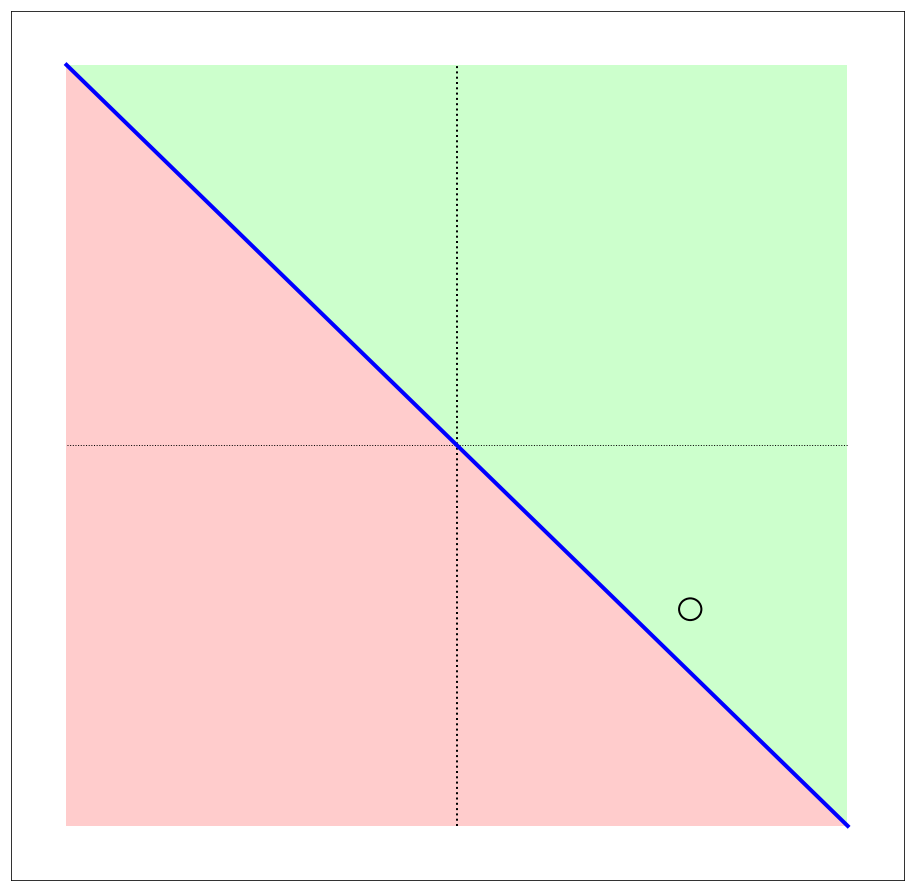

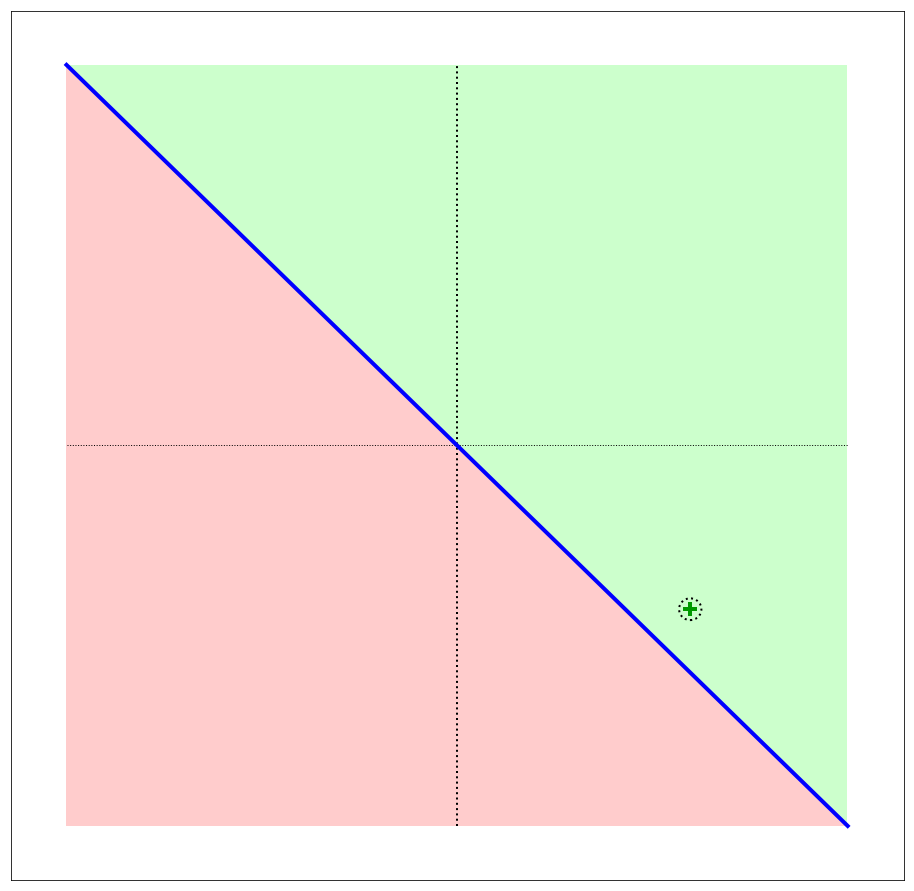

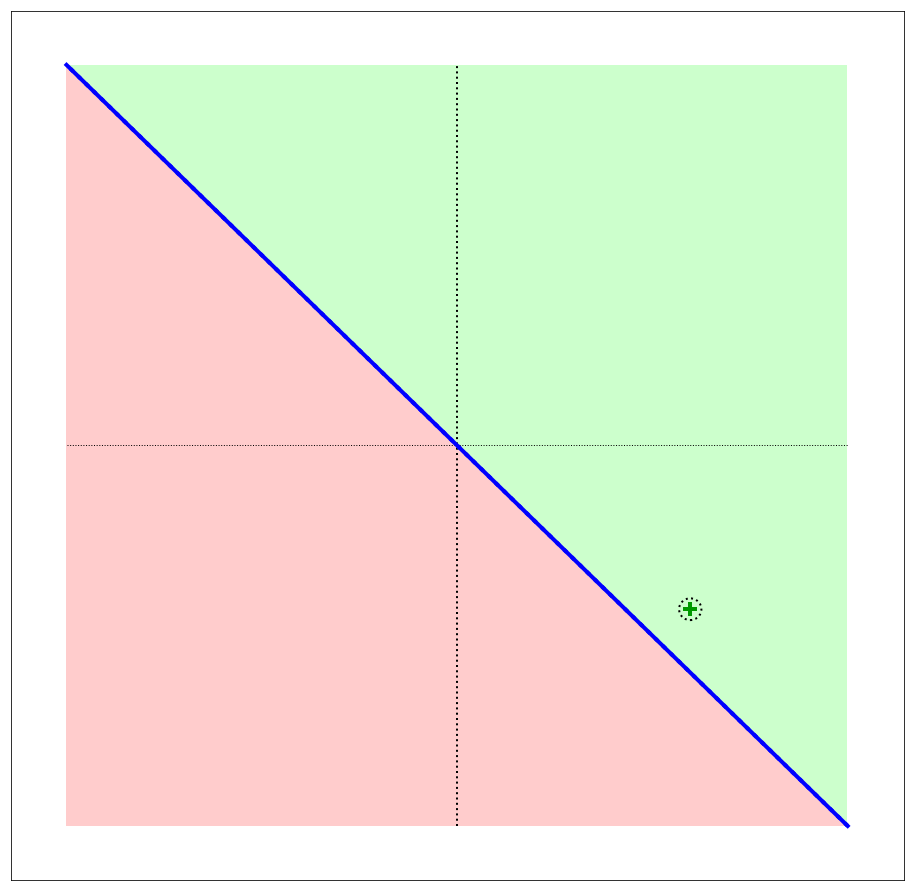

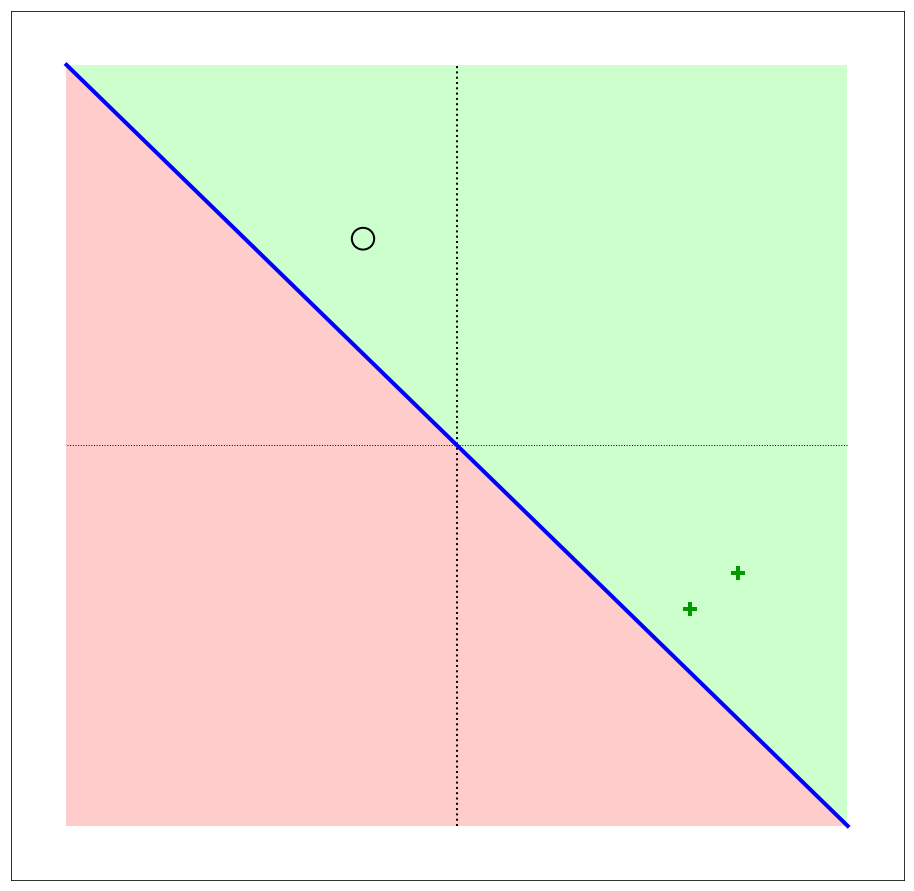

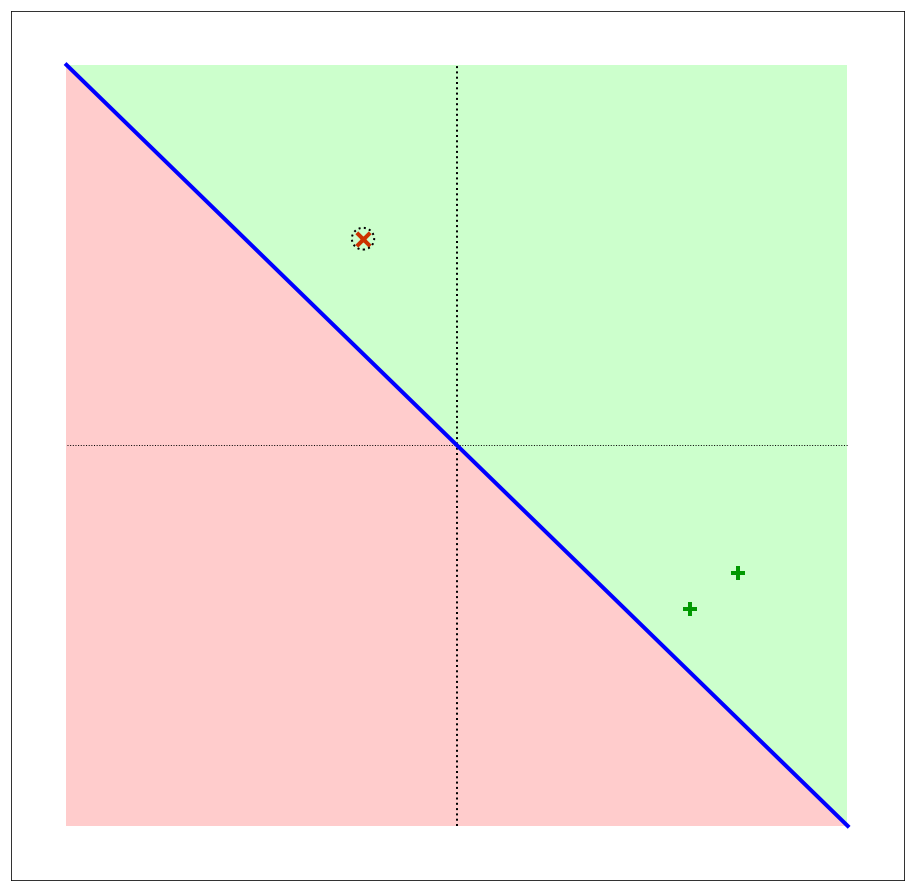

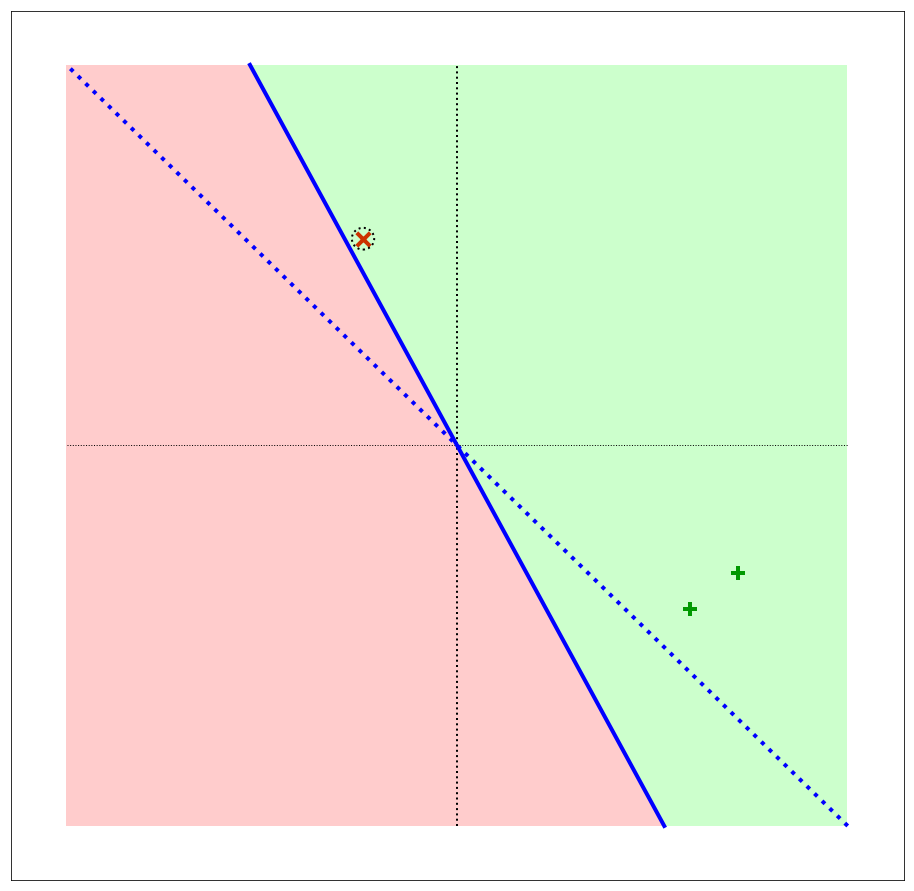

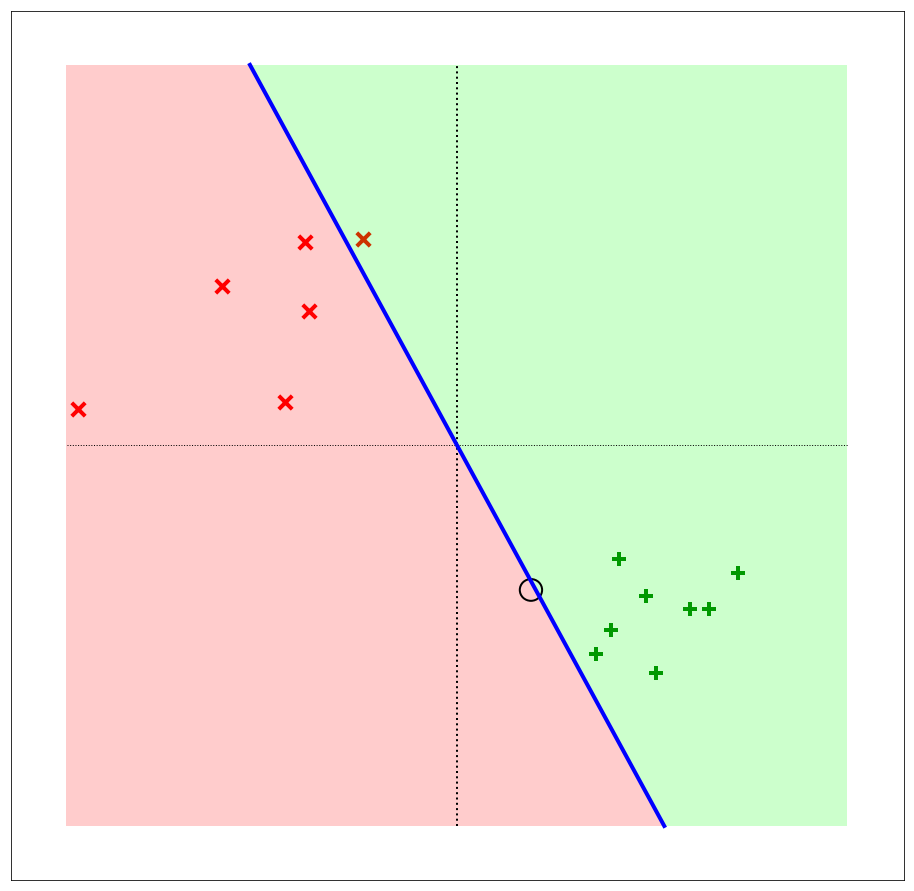

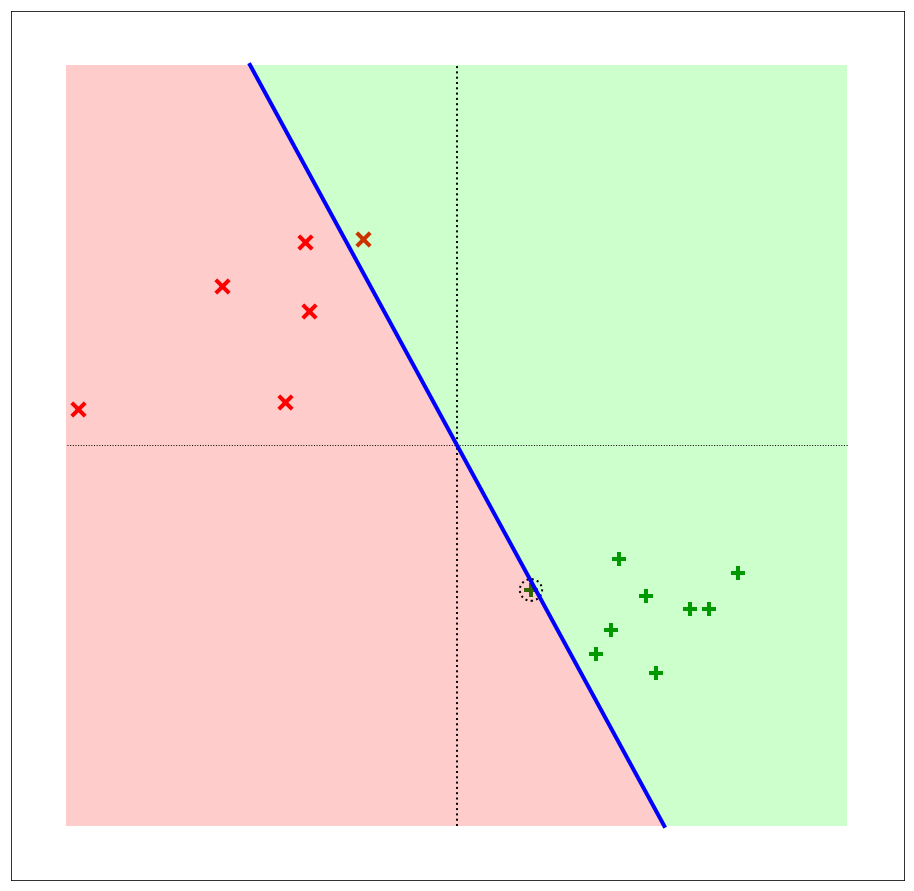

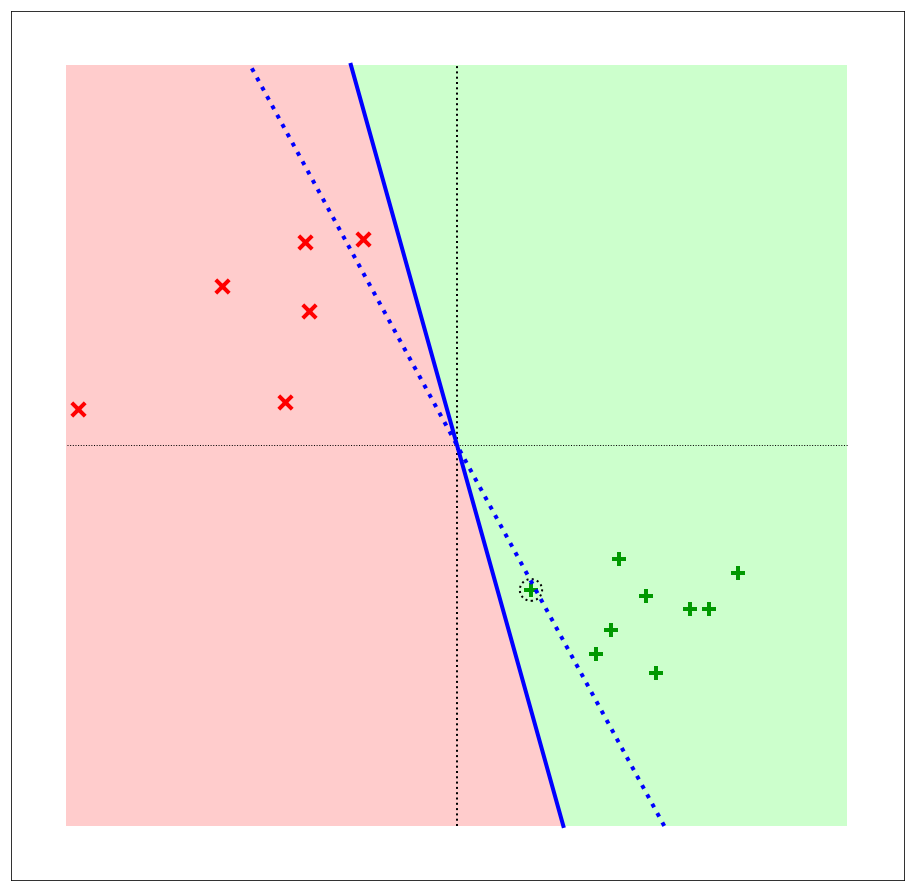

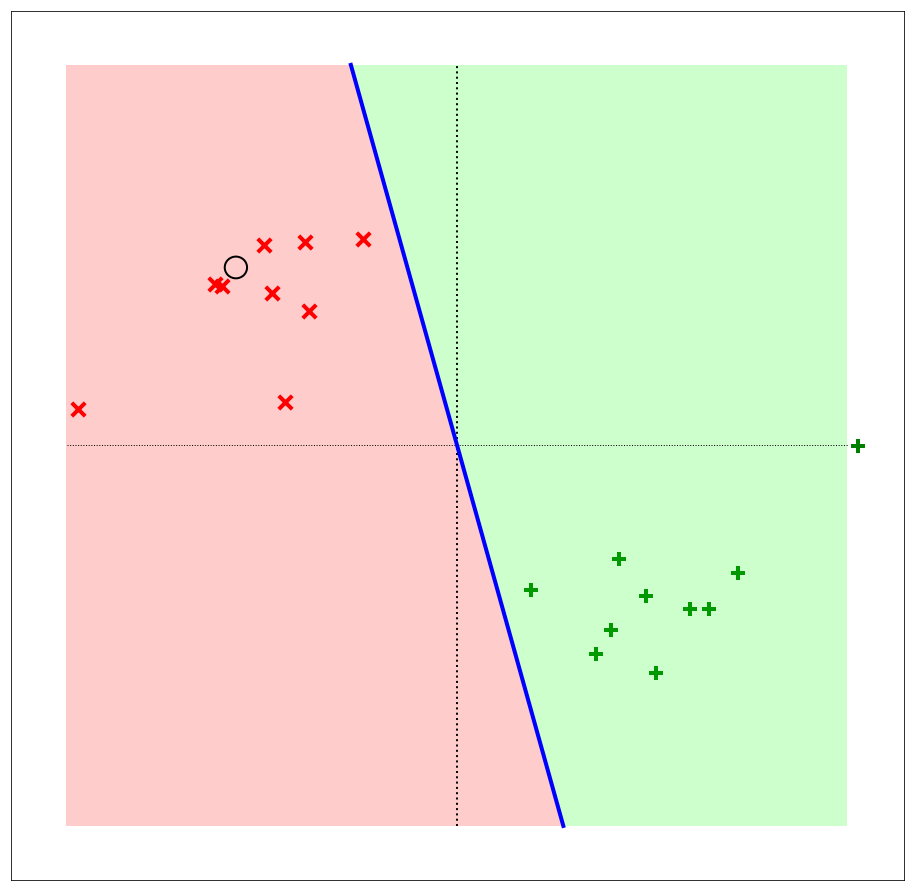

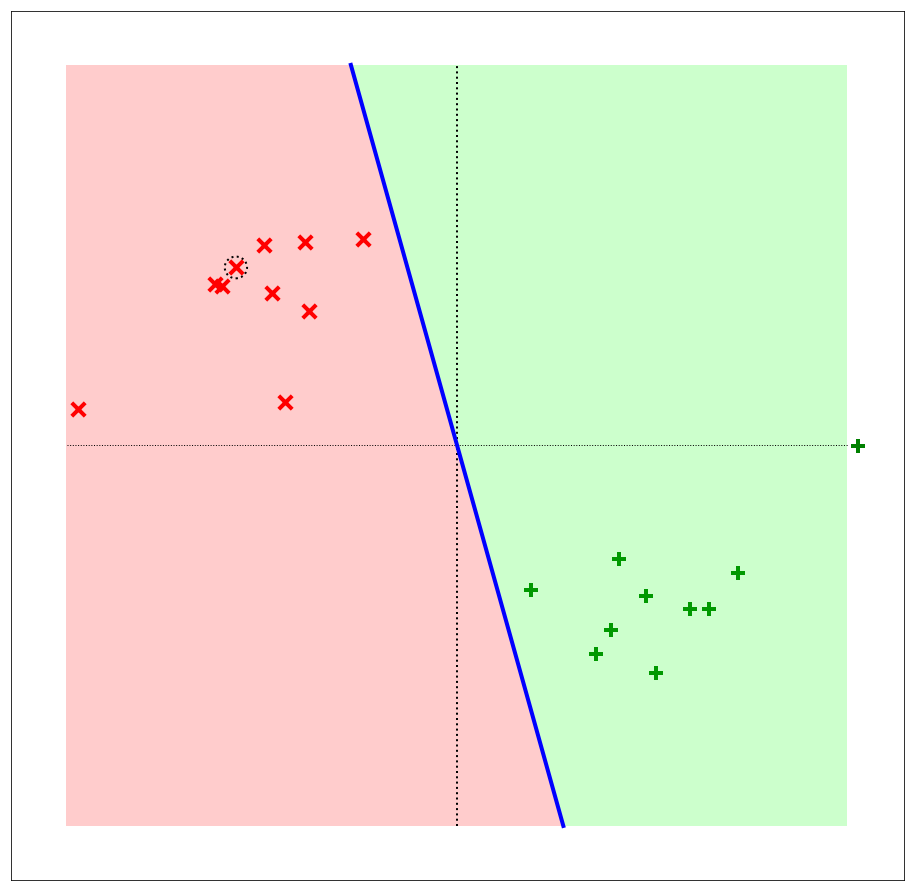

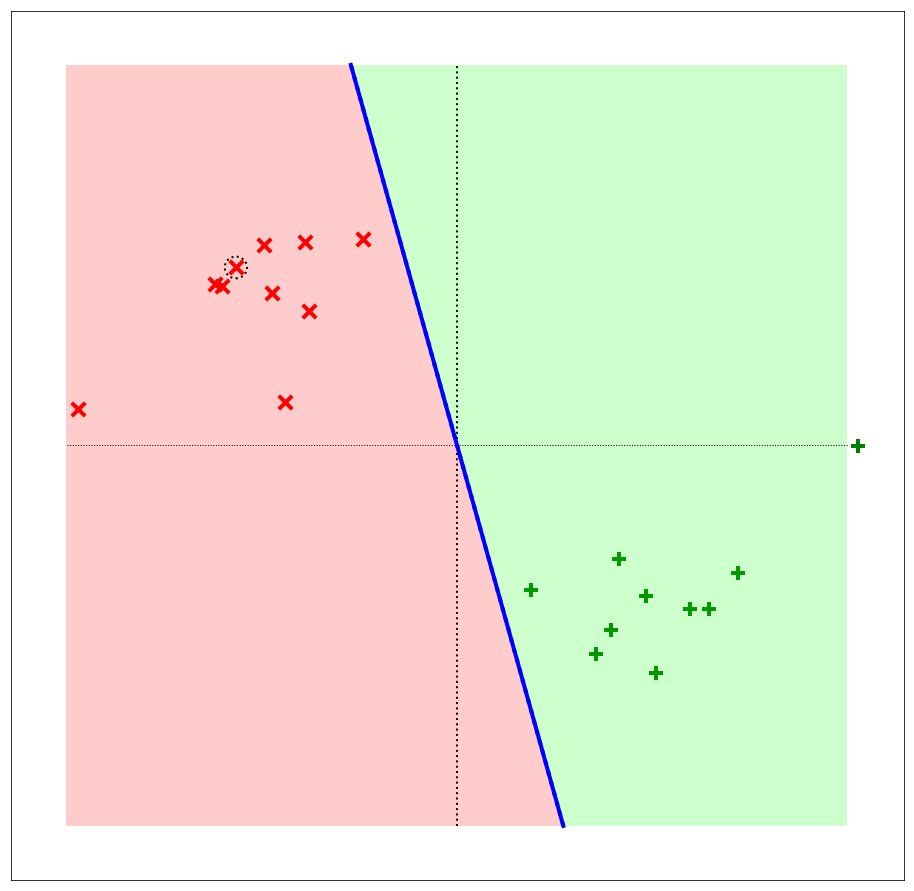

In [6]:
# Let's find some interesting stages and plot them
make_plots = [0] + [i for i in range(len(yhat)) if yhat[i] != y[i]] + [len(y) - 1]
for iter in make_plots:
    for stage in ['predict', 'reveal', 'update']:
        filename = 'plot_' + str(iter) + '_' + stage + '.png'
        makePlots(w_traj[:iter+2], X[:iter + 1], y[:iter + 1], stage=stage, filename=filename)